# QPSK Single-Carrier Transmission Chain
This notebook walks through each step of a QPSK single-carrier digital transmission system, including pulse shaping and RF upconversion.

## 1. Generate Random Bits

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import upfirdn
from numpy.fft import fft, fftshift

# Parameters
bit_rate = 1e3  # bits per second
symbol_rate = bit_rate / 2  # QPSK: 2 bits per symbol
T_sym = 1 / symbol_rate
fs = 16e3  # Sampling frequency
samples_per_symbol = int(fs / symbol_rate)
num_symbols = 10
beta = 0.35
span = 6

# Generate bits
bits = np.random.randint(0, 2, num_symbols * 2)
print("Bits:", bits)

Bits: [1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0]


## 2. Map Bits to QPSK Symbols

In [3]:
def qpsk_map(b):
    mapping = {
        (0, 0): 1 + 1j,
        (0, 1): -1 + 1j,
        (1, 1): -1 - 1j,
        (1, 0): 1 - 1j
    }
    return mapping[tuple(b)]

symbols = np.array([qpsk_map(bits[i:i+2]) for i in range(0, len(bits), 2)])
print("QPSK Symbols:", symbols)

QPSK Symbols: [ 1.-1.j  1.+1.j -1.-1.j  1.-1.j  1.+1.j -1.+1.j  1.-1.j  1.-1.j  1.-1.j
  1.-1.j]


## 3. Apply Pulse Shaping with Raised Cosine Filter

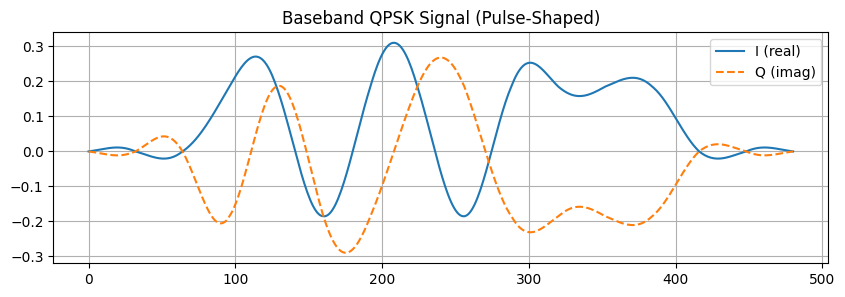

In [4]:
def raised_cosine_filter(beta, sps, span):
    N = span * sps
    t = np.arange(-N/2, N/2 + 1) / sps
    h = np.sinc(t) * np.cos(np.pi * beta * t) / (1 - (2 * beta * t)**2)
    h[t == 0] = 1.0
    h[np.abs(2 * beta * t) == 1] = np.pi / 4 * np.sinc(1 / (2 * beta))
    return h / np.sqrt(np.sum(h**2))

rc_filter = raised_cosine_filter(beta, samples_per_symbol, span)

# Upsample and filter
tx_signal = upfirdn(rc_filter, symbols, samples_per_symbol)

plt.figure(figsize=(10, 3))
plt.plot(np.real(tx_signal), label='I (real)')
plt.plot(np.imag(tx_signal), label='Q (imag)', linestyle='--')
plt.title("Baseband QPSK Signal (Pulse-Shaped)")
plt.legend()
plt.grid(True)
plt.show()

## 4. Separate I and Q Components

In [8]:
I = np.real(tx_signal)
Q = np.imag(tx_signal)

## 5. Modulate onto a Carrier

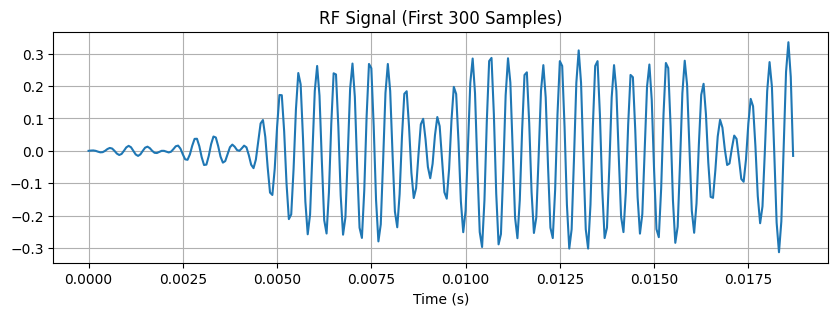

In [9]:
fc = 2e3  # Carrier frequency
t = np.arange(len(tx_signal)) / fs
carrier = I * np.cos(2 * np.pi * fc * t) - Q * np.sin(2 * np.pi * fc * t)

plt.figure(figsize=(10, 3))
plt.plot(t[:300], carrier[:300])
plt.title("RF Signal (First 300 Samples)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

## 6. Spectrum Analysis

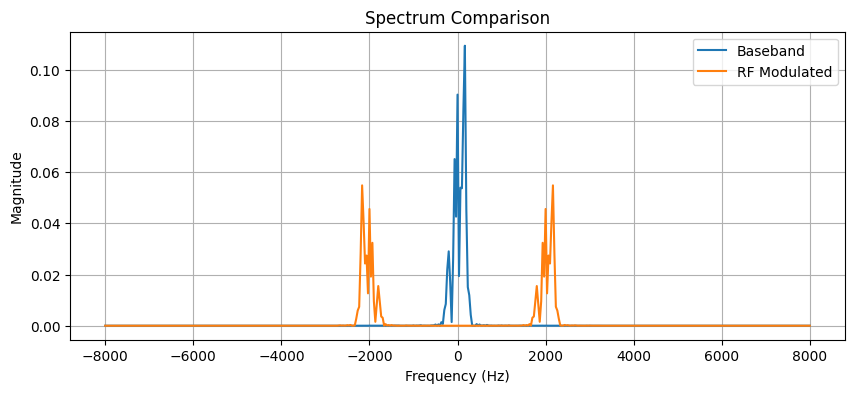

In [10]:
def compute_spectrum(signal, fs):
    N = len(signal)
    f = np.linspace(-fs/2, fs/2, N)
    spectrum = np.abs(fftshift(fft(signal))) / N
    return f, spectrum

f_base, spec_base = compute_spectrum(tx_signal, fs)
f_rf, spec_rf = compute_spectrum(carrier, fs)

plt.figure(figsize=(10, 4))
plt.plot(f_base, spec_base, label='Baseband')
plt.plot(f_rf, spec_rf, label='RF Modulated')
plt.title("Spectrum Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()